# Experiment 000

In this experiment, we try out different model architectures to see if we can improve the board accuracy.

In [1]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __len__(self):
        return self.highest_index

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx+1}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        b1, b2 = np.load(file, allow_pickle=True)
        b1 = torch.tensor(b1.astype(np.int32), dtype=torch.int)
        b2 = torch.tensor(b2.astype(np.int32), dtype=torch.long)
        return b1, b2 # b1 is the input board, b2 is the output board
        

In [3]:
dataset = RecordingDataset("data")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

x, y = next(iter(dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 22, 10]) torch.int32
torch.Size([4, 22, 10]) torch.int64


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class OriginalModel(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of int32 of shape (batch_size, height, width). height = 22 and width = 10 are the dimensions of the game
           board. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: Tensor of float32 of shape (batch_size, height, width), logits for the new cells. Probabilities close to 0 (negative logits)
             correspond to empty cells, and probabilities close to 1 (positive logits) correspond to blocks.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 1)
        self.conv2 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.pad(x, (1, 1, 1, 1)) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        logits = F.log_softmax(self.conv2(x), dim=1)
        return logits

In [32]:
class ModelWithLargerCapacity(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv0 = nn.Conv2d(2, channels, 3)
        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.conv2 = nn.Conv2d(channels, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv1(x))
        logits = F.log_softmax(self.conv2(x), dim=1)
        return logits

In [21]:
class ModelWithTwo3x3Convs(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [17]:
class ModelWithThree3x3Convs(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3)
        self.conv1 = nn.Conv2d(10, 10, 3)
        self.conv2 = nn.Conv2d(10, 10, 3)
        self.conv3 = nn.Conv2d(10, 10, 1)
        self.conv4 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv1(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv2(F.pad(x, (1, 1, 1, 1))))
        x = F.relu(self.conv3(x))
        logits = F.log_softmax(self.conv4(x), dim=1)
        return logits

In [18]:
class ModelWith5x5Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 5)
        self.conv1 = nn.Conv2d(10, 10, 1)
        self.conv2 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (2, 2, 2, 2))))
        x = F.relu(self.conv1(x))
        logits = F.log_softmax(self.conv2(x), dim=1)
        return logits

In [37]:
class ModelWith7x7Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 7)
        self.conv1 = nn.Conv2d(10, 10, 1)
        self.conv2 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(F.pad(x, (3, 3, 3, 3))))
        x = F.relu(self.conv1(x))
        logits = F.log_softmax(self.conv2(x), dim=1)
        return logits

In [30]:
model = ModelWithLargerCapacity(20).to(device)
print(model)

X, y = next(iter(dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

ModelWithLargerCapacity(
  (conv0): Conv2d(2, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(20, 2, kernel_size=(1, 1), stride=(1, 1))
)
Predicted states: tensor([[[0.3156, 0.3119, 0.3119, 0.3119, 0.3119, 0.3119, 0.3119, 0.3119,
          0.3119, 0.3096],
         [0.3178, 0.3110, 0.3142, 0.3125, 0.3166, 0.3110, 0.3110, 0.3110,
          0.3110, 0.3122],
         [0.3178, 0.3110, 0.3177, 0.3150, 0.3137, 0.3184, 0.3166, 0.3110,
          0.3110, 0.3122],
         [0.3178, 0.3110, 0.3133, 0.3113, 0.3160, 0.3084, 0.3115, 0.3110,
          0.3110, 0.3122],
         [0.3178, 0.3110, 0.3056, 0.3032, 0.3078, 0.3136, 0.3135, 0.3110,
          0.3110, 0.3122],
         [0.3178, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110,
          0.3110, 0.3122],
         [0.3178, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110,
          0.3110, 0.3122],
         [0.3178, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0.3110, 0

In [40]:
def train_loop(dataloader, model, loss_fn, optimizer):
    avg_loss = 0.0

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
    
    avg_loss /= size
    return avg_loss


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss, correct, board_correct = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            classes = torch.argmax(pred, dim=1)
            correct += (classes == y).type(torch.float).mean().item()
            board_correct += (classes == y).all(-1).all(-1).type(torch.float).mean().item()

    test_loss /= num_batches
    correct /= num_batches
    board_correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Board accuracy: {(100*board_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct,
        "acc_board": board_correct
    }

In [49]:
models = {
    "original": OriginalModel().to(device),
    "larger capacity": ModelWithLargerCapacity(25).to(device),
    "two 3x3 convs": ModelWithTwo3x3Convs().to(device),
    "three 3x3 convs": ModelWithThree3x3Convs().to(device),
    "5x5 conv": ModelWith5x5Conv().to(device),
    "7x7 conv": ModelWith7x7Conv().to(device),
}

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, model in models.items():
    print(f"Model '{name}' has {count_parameters(model)} parameters.")

Model 'original' has 322 parameters.
Model 'larger capacity' has 1177 parameters.
Model 'two 3x3 convs' has 1232 parameters.
Model 'three 3x3 convs' has 2142 parameters.
Model '5x5 conv' has 642 parameters.
Model '7x7 conv' has 1122 parameters.


Training model 'original'...
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 92.2%, Board accuracy: 0.0%, Avg loss: 0.203126 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 92.1%, Board accuracy: 0.0%, Avg loss: 0.151543 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 92.7%, Board accuracy: 0.0%, Avg loss: 0.113063 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.0%, Board accuracy: 0.0%, Avg loss: 0.092332 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.7%, Board accuracy: 0.0%, Avg loss: 0.079093 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 96.9%, Board accuracy: 0.0%, Avg loss: 0.069478 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.9%, Board accuracy: 0.6%, Avg loss: 0.062226 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.0%, Board accuracy: 0.6%, Avg loss: 0.056453 

Epoch 9
-------------------------------
Test Error: 
 Accur

[]

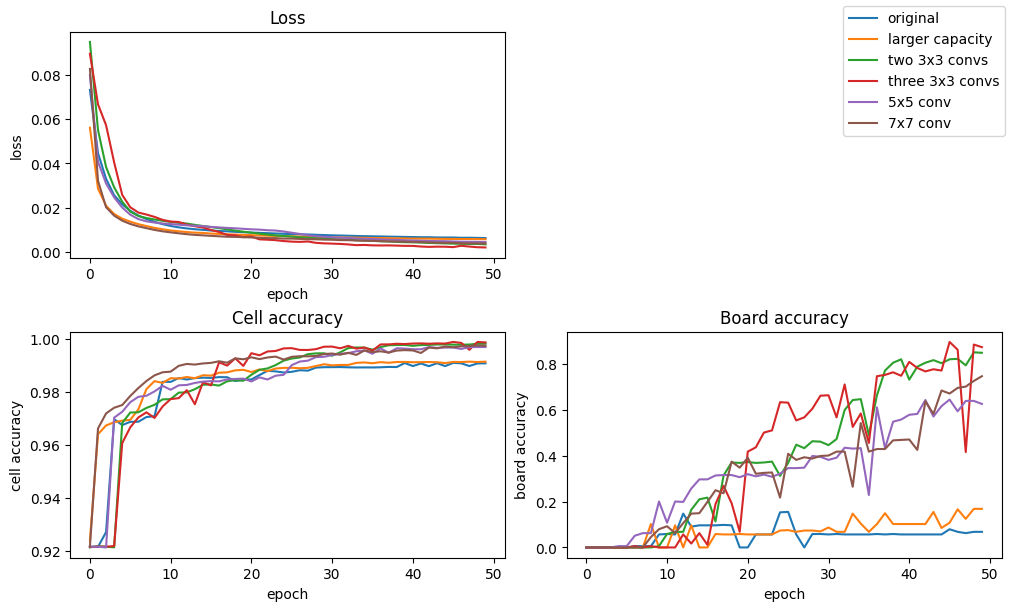

In [50]:
learning_rate = 1e-1
epochs = 50

fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
axs = axs.flatten()
ax_loss, ax_legend, ax_acc, ax_acc_board = axs

ax_loss.set_title("Loss")
ax_loss.set_xlabel("epoch")
ax_loss.set_ylabel("loss")

ax_legend.set_visible(False)

ax_acc.set_title("Cell accuracy")
ax_acc.set_xlabel("epoch")
ax_acc.set_ylabel("cell accuracy")

ax_acc_board.set_title("Board accuracy")
ax_acc_board.set_xlabel("epoch")
ax_acc_board.set_ylabel("board accuracy")

for key, model in models.items():
    print(f"Training model '{key}'...")
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    loss_history = []
    acc_history = []
    board_acc_history = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # Since our dataset represents the full set of possible states, we can safely use it for both training and testing
        epoch_loss = train_loop(dataloader, model, loss_fn, optimizer)
        loss_history.append(epoch_loss)
        # No need to plot test loss separately as in our case it's the same as training loss
        test_metrics = test_loop(dataloader, model, loss_fn)
        acc_history.append(test_metrics["acc"])
        board_acc_history.append(test_metrics["acc_board"])

    print("Training done!")

    ax_loss.plot(loss_history, label=key)
    ax_acc.plot(acc_history, label=key)
    ax_acc_board.plot(board_acc_history, label=key)

handles, labels = ax_loss.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.plot()

# Discussion of models

'original' is the baseline model to which we are comparing the others. We have tried altering this model in multiple ways. '5x5 conv' and '7x7 conv' increase only the kernel size of the first convolutional layer. 'two 3x3 convs' and 'three 3x3 convs' increase the number of 3x3 convolutional layers. 'larger capacity' just increases the number of channels without altering the "shape" of the model. 'larger capacity', 'two 3x3 convs' and '7x7 conv' have roughly the same number of trainable parameters.


# Conclusion

Of all the models tested here, 'two 3x3 convs' and 'three 3x3 convs' seem to have the best performance. '5x5 conv' and '7x7 conv' are still much better than the baseline, but some sources online seem to advise using 3x3 stacks of 3x3 convolutional filters over larger kernel sizes. I expect this is especially true in the current use case, because the input is much more information-dense than an image.

The model 'three 3x3 convs' displays some instability during training, perhaps due to the larger number of parameters or the fact that it is the deepest model. This could perhaps be mitigated by batch normalization or using larger batch sizes.

To keep things simple, I will use the 'two 3x3 convs' architecture.